# Module 3 Sprint 3 Lending Club part 3

The final part of the Lending Club project, this notebook focuses on classification of loan sub-grades and interst rates for newly accepted loans.


In this notebook the cleaned dataset from part 2 is re-used, a few new features introduced including historical economic data that does influence loan and mortgage rates within US. Features include gross domestic product, interest rates for long term government bonds, US/Euro foreign exchange rate and consumer price index.

Feature importance will be evaluated using the baseline model for sub-grade predictions and SHAP values for the interes rate predictions.

Models will be tuned using Bayesian Hyperparameter optimization tool - Optuna. Models will be evaluated using holdout validation and test sets.

Evaluation metric chosen for loan sub-grade classificaiton is Macro F1, as with the loan grade prediction in part 2 of the project we need high precission and recall for every class as failing to corretcly classify the loan sub-grade will have an impact on further evaluation criteria like interest rate. Innacurate predictions misslabeling loans increases the risk exposure to Lendgin Club loan funders and can be a violation of financial regulation.

Interest rate regression model will be evaluated using Root Mean Squared Error value (RMSE) for easier interpretability, but also increasing sensitivity to outliers which can originate from lower accuracy of loan grade and sub-grade predictions. Adjusted R-squared value will also be used to evaluate how well do the features in the model can explain the target variance.

In [1]:
import sys
import os

sys.path.append("src")

In [2]:
import pandas as pd
import pandas_datareader as pdr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    f1_score,
)
from lightgbm import LGBMClassifier, LGBMRegressor


import shap
import optuna
import joblib

# helper functions
import plots as plot
import utils as utl

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
RANDOM_SEED = 42

Import dataset prepared from part 2

In [5]:
df = pd.read_pickle("sub_grad_dataset")

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2260667 entries, 0 to 2260698
Data columns (total 20 columns):
 #   Column                Dtype         
---  ------                -----         
 0   loan_amnt             float64       
 1   term                  object        
 2   int_rate              float64       
 3   grade                 object        
 4   sub_grade             object        
 5   emp_length            object        
 6   home_ownership        object        
 7   verification_status   object        
 8   issue_d               datetime64[ns]
 9   purpose               object        
 10  addr_state            object        
 11  dti                   float64       
 12  delinq_2yrs           float64       
 13  open_acc              float64       
 14  pub_rec               float64       
 15  total_acc             float64       
 16  application_type      object        
 17  pub_rec_bankruptcies  float64       
 18  fico                  float64       
 19  Year 

Quick check if the dataframe has no missing values

In [7]:
df.isna().sum().sum()

0

Interest rates are driven by grade and subgrade, but there are also external economic factors that can play a role in determining interest rates. Lets try and investigate federal interest rate, CPI, GDP and other factors to check if we can support our prediction on them

In [8]:
indicators = ["CPIAUCNS", "GDP", "IR14270", "EXUSEU"]
start_date, end_date = "2007-06-01", "2018-12-01"
economic_df = pdr.get_data_fred(indicators, start_date, end_date).reset_index()

In [9]:
economic_df.columns = ["DATE", "CPI", "GDP", "FED_int_rate", "exch_rate"]
economic_df["DATE"] = economic_df["DATE"].dt.year
metrics_annual = economic_df.groupby(by="DATE").agg("mean")

Merge new features into the full dataframe

In [10]:
df = pd.merge(df, metrics_annual, left_on="Year", right_on="DATE")

## EDA

Most of the eda for the features can be found in Parts 1 and 2 of the project, we will have another look at the distributions of both loan sub-grade and interest rate before moving on to machine learning


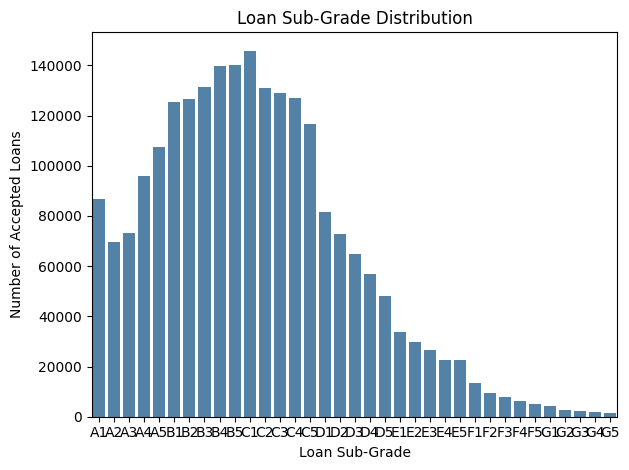

In [11]:
sub_grades = df["sub_grade"].sort_values()
ax = sns.countplot(sub_grades, x=sub_grades.values, color="steelblue")
ax.set_title("Loan Sub-Grade Distribution")
ax.set_ylabel("Number of Accepted Loans")
ax.set_xlabel("Loan Sub-Grade")
plt.tight_layout()

Looking at the distribution with the intention to classify these loan sub-grades the uneasy feeling is creeping in, the long taper to the right indicates that there dataset is unbalanced and quite a few classes are underrepresented. Combine that with the fact that there are 35 of these distinct classes and they are squeezed tightly in the space it will be challenge to achieve any high model metric scores.

A quick check to see how much of the dataset do the lowest sub-grade loans actually represent

In [12]:
print(f"{(len(df[df['sub_grade'].str.contains('G4|G5')])/len(df))*100:.2f}%")

0.15%


So the lowest G4 and G5 sub grade loans are combined are actually only 0.15% of the dataset, it will be very hard to predict these classes or interest rates for these classes.



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



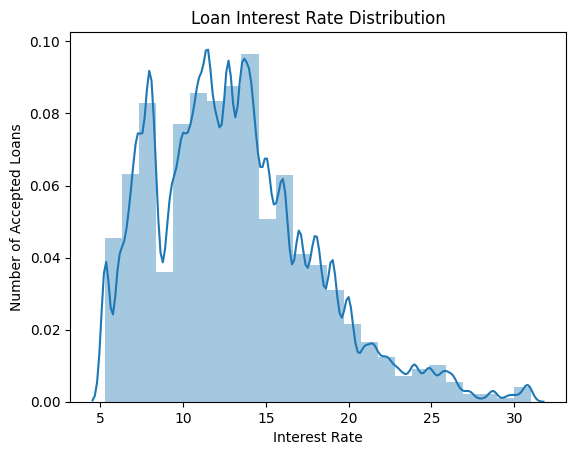

In [13]:
ax = sns.distplot(df["int_rate"], bins=25)
ax.set_title("Loan Interest Rate Distribution")
ax.set_ylabel("Number of Accepted Loans")
ax.set_xlabel("Interest Rate");

Similar right skew on the interest rate distribution, as to be expected - high loan interest rates are associated with risk, which in this dataset is expressed through grade and sub grade, so the shapes of interest rate distribution an loan sub-grade distribution should be following suit. Also who would pay more than 20% interest rate on a consumer loan??

## Machine learning 

We will create two models: Loan sub-grade classifier and Interest Rate regressor

Before each of the models are created, baseline models will be generated to set benchmark scores. The dataset will be divided into train,validation,test sets with 60%,20%,20% proportions. Baseline model evaluation and hyperparameter tuning will be done using validation set, final models will be tested on the test part of the dataset.

Feature importance and selection will be done using SHAP analysis of the baseline model

The chosen metric for the multiclass loan sub-grade classifier is the same as the previously used F1 Macro, we will also check the balanced accuracy

For interest rate regressor we will use root mean squared error as our main model accuracy metric and also the adjusted R-squared value to check the explained variance.



### Loan sub-grade prediction

#### Data preparation

Remove high cardinality columns and columns which would introduce data leakage

In [14]:
cols_to_drop = ["int_rate", "issue_d", "purpose", "addr_state"]

In [15]:
df_clf = df.drop(columns=cols_to_drop)

Separate our target feature - sub_grade

In [16]:
X = df_clf.drop(["sub_grade"], axis=1)
y = df_clf["sub_grade"]

#### Pipelines

In [17]:
num_cols = [
    "loan_amnt",
    "term",
    "dti",
    "fico",
    "emp_length",
    "delinq_2yrs",
    "open_acc",
    "pub_rec",
    "total_acc",
    "pub_rec_bankruptcies",
    "CPI",
    "GDP",
    "FED_int_rate",
    "exch_rate",
    "Year"
]
cat_cols = ["grade", "home_ownership", "verification_status", "application_type"]

In [18]:
numerical_transformer = Pipeline([("scaler", StandardScaler())])
categorical_tranformer = Pipeline([("encoder", OneHotEncoder())])

In [19]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, num_cols),
        ("cat", categorical_tranformer, cat_cols),
    ]
)

### Baseline model and feature importance

In part 2 we have seen that tree based models perform the best in multiclass classification for loan grades. We will use the same method for feature importance check and will set a baseline for the loan sub-grade classification.

In [20]:
pipe = Pipeline(
    [
        ("preprocessor", preprocessor),
        (
            "classifier",
            LGBMClassifier(random_state=RANDOM_SEED,verbose=-1),
        ),
    ]
)

In [21]:
X_train,X_test,y_train,y_test=utl.sample_and_split(df_clf,'sub_grade',n=500000,random_seed=RANDOM_SEED)

In [22]:
baseline_clf=pipe.fit(X_train,y_train)

In [23]:
y_pred = baseline_clf.predict(X_test)
print(f"Macro F1 score for baseline model:{f1_score(y_test,y_pred,average='macro'):.2f}")

Macro F1 score for baseline model:0.21


#### Feature importance

In [24]:
shap.initjs()

In [25]:
preprocessor = baseline_clf.named_steps["preprocessor"]

In [26]:
ohe_categories = preprocessor.named_transformers_["cat"][0].categories_
new_ohe_features = [
    f"{col}__{val}" for col, vals in zip(cat_cols, ohe_categories) for val in vals
]
all_features = num_cols + new_ohe_features

In [27]:
explainer = shap.TreeExplainer(baseline_clf["classifier"])

In [28]:
observations = baseline_clf["preprocessor"].transform(
    X_train.sample(1000, random_state=RANDOM_SEED)
)
shap_values = explainer.shap_values(observations)

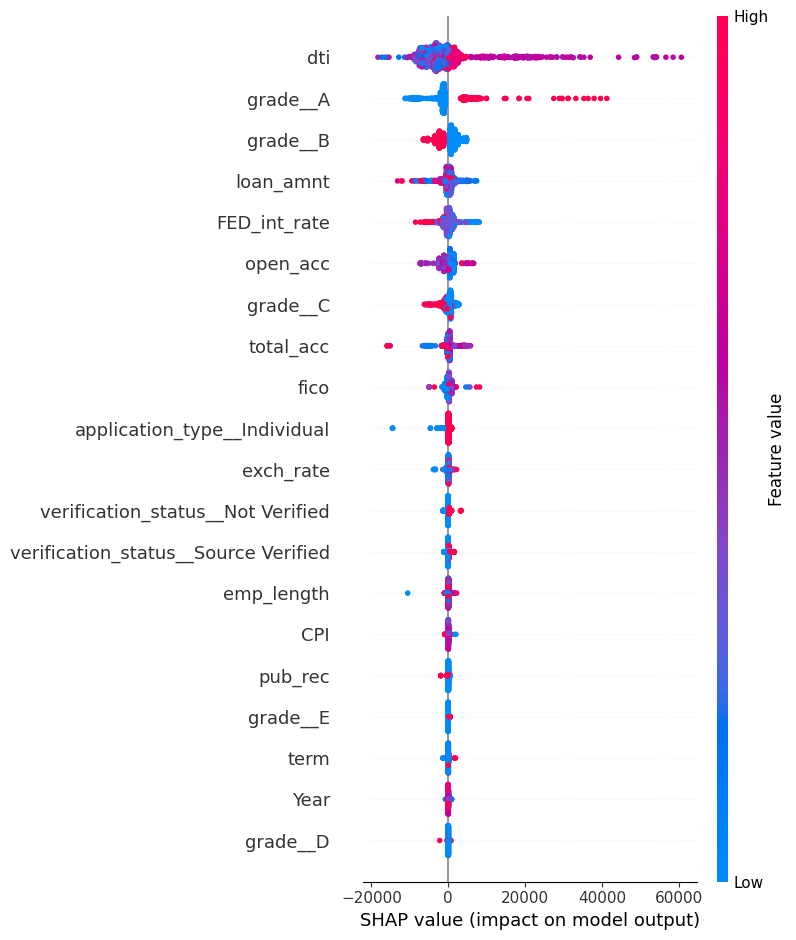

In [29]:
shap.summary_plot(shap_values[0], features=observations, feature_names=all_features)

Above visualization shows the impact of each feature in the model explained by SHAP value. FICO score, Grade of the loan, debt to income ratio are the top features of importance. We will drop the features with very small or no impact on the model.
*Worth noting that features with 0 impact are not showing up on the plot

In [30]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          A1       0.38      0.49      0.42      5635
          A2       0.23      0.12      0.16      4628
          A3       0.17      0.12      0.14      5025
          A4       0.30      0.21      0.25      6318
          A5       0.35      0.56      0.43      7326
          B1       0.28      0.36      0.32      8265
          B2       0.14      0.21      0.17      8378
          B3       0.23      0.18      0.20      8692
          B4       0.26      0.20      0.22      9228
          B5       0.29      0.35      0.32      9267
          C1       0.27      0.55      0.36      9741
          C2       0.21      0.17      0.19      8541
          C3       0.21      0.09      0.13      8650
          C4       0.24      0.17      0.20      8530
          C5       0.23      0.13      0.17      7727
          D1       0.29      0.47      0.35      5298
          D2       0.24      0.22      0.23      4846
          D3       0.21    

List and drop low impact features

In [31]:
low_impact_features = [
    "exch_rate",
    "delinq_2yrs",
    "pub_rec",
    "pub_rec_bankruptcies",
    "application_type",
    "home_ownership",
    "FED_int_rate",
    "verification_status",
    "GDP"
]

In [32]:
df_clf=df_clf.drop(columns=low_impact_features)

Reset the pipelines with new columns 

In [33]:
X = df_clf.drop(["sub_grade"], axis=1)
y = df_clf["sub_grade"]

In [34]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num",numerical_transformer, ['loan_amnt','term','emp_length','total_acc','open_acc','fico','Year','CPI']),
        ("cat", categorical_tranformer, ['grade'])
    ]
)

In [35]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=RANDOM_SEED
)
X_test, X_val, y_test, y_val = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=RANDOM_SEED
)

####  LightGBM model hyperparameter tuning

In [36]:
def objective(trial):
    param = {
        "objective": "multiclass",
        "num_class": 35,
        "boosting_type": "gbdt",
        "metric": "multi_logloss",
        "verbose": -1,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 31, 128),
        "subsample_for_bin": trial.suggest_int("subsample_for_bin", 10000, 40000),
        "n_estimators": trial.suggest_int("n_estimators", 2, 100),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.8, 1.0),
        "subsample": trial.suggest_float("subsample", 0.8, 1.0),
        "max_depth": trial.suggest_int("max_depth", 3, 19),
        "min_child_samples": trial.suggest_int("min_child_samples", 1, 50),
        "min_chil_weight": trial.suggest_float("min_child_weight", 0.001, 0.005),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.1, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.1, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 1.0),
    }

    model = LGBMClassifier(**param, random_state=RANDOM_SEED)
    model.fit(preprocessor.fit_transform(X_train), y_train)
    predictions = model.predict(preprocessor.fit_transform(X_val))
    f1_macro = f1_score(y_val, predictions, average="macro")
    return f1_macro

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

In [38]:
print(f"Best model F1 macro score for validation set: {study.best_value:.2f}")

Best model F1 macro score for validation set: 0.23


Create a pipeline with the best model parameters

In [39]:
pipe = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("classifier", LGBMClassifier(**study.best_params, verbose=-1)),
    ]
)

In [40]:
subgrade_clf = pipe.fit(X_train, y_train)

And we can test the model on the holdout set

In [41]:
y_pred = subgrade_clf.predict(X_test)
f1_score(y_test, y_pred, average="macro")
print(
    f"Best model F1 macro score on test set:{f1_score(y_test,y_pred,average='macro'):.2f}"
)

Best model F1 macro score on test set:0.23


Full classification report for the final model

In [42]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          A1       0.37      0.59      0.46     17363
          A2       0.27      0.11      0.15     13870
          A3       0.28      0.04      0.07     14662
          A4       0.33      0.23      0.27     18964
          A5       0.37      0.66      0.48     21497
          B1       0.29      0.40      0.33     25219
          B2       0.28      0.11      0.16     25257
          B3       0.27      0.11      0.16     26375
          B4       0.27      0.25      0.26     27966
          B5       0.28      0.50      0.36     28126
          C1       0.26      0.68      0.38     29032
          C2       0.25      0.09      0.13     26179
          C3       0.22      0.10      0.14     25784
          C4       0.25      0.23      0.24     25339
          C5       0.28      0.12      0.17     23649
          D1       0.28      0.76      0.41     16251
          D2       0.26      0.23      0.24     14602
          D3       0.29    

With the final Macro F1 score of 0.23 the multiclass classifier is not looking good, as expected earlier the underrepresentation in the dataset for the lowest sub-grade loans is making it difficult to classify correctly. Also high cardinality of the target feature in the space (total of 35 distinct classes) is also making it difficult to achieve any decent scores.

### Interest Rate prediction

We will use a simple Linear Regression model as a baseline model and a LightGBM Regressor to determine the loan interest rate capturing non linear relationships among the features.

Since interest rate is derived from loan grade and sub grade we will use the same features as in the loan sub-grade classification.

In [43]:
num_cols = [
    "loan_amnt",
    "term",
    "dti",
    "total_acc",
    "fico",
    "emp_length",
    "open_acc",
    "CPI",
    "exch_rate",
    "Year"
]
cat_cols = [
    "sub_grade",
    "grade",
]

In [44]:
X = df[num_cols+cat_cols]
y = df["int_rate"]

In [45]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=RANDOM_SEED
)
X_test, X_val, y_test, y_val = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=RANDOM_SEED
)

In [46]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, num_cols),
        ("cat", categorical_tranformer, cat_cols),
    ]
)

#### Baseline model

In [47]:
pipe = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("regressor", LinearRegression()),
    ]
)

In [48]:
rf_baseline = pipe.fit(X_train, y_train)

Test the model on validation set and print the root mean squared error

In [49]:
y_pred = rf_baseline.predict(X_val)

In [50]:
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

In [51]:
print(f"Root Mean Squared Error of the baseline model:{rmse:.2f}")

Root Mean Squared Error of the baseline model:0.92


Lets also look at the adjusted R squared value 

In [52]:
n = len(y_test)
p = preprocessor.transform(X_val).shape[1]
r_squared = r2_score(y_val, y_pred)
adjusted_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - p - 1)

In [53]:
print(f"Adjusted R.sq value of the baseline model:{adjusted_r_squared:.2f}")

Adjusted R.sq value of the baseline model:0.96


Adjusted R.sq value suggest that the features used in the baseline model prediction can explain ~96,8% of target feature variance, which is a really good result.

To investigate further we will look at the residuals plot.

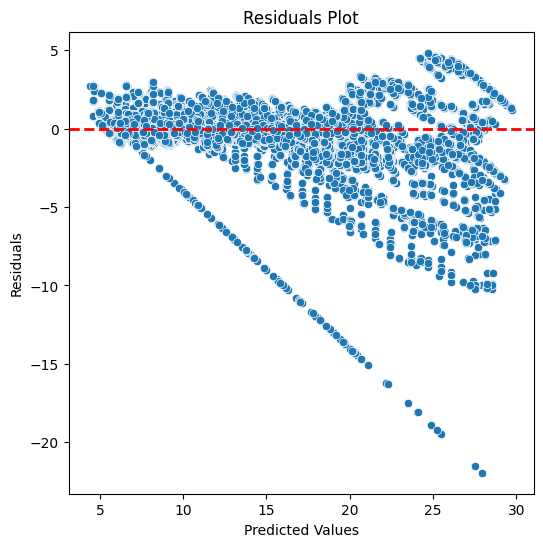

In [54]:
plot.plot_residuals(y_val, y_pred)

The funnel shape of the residuals towards the higher prediction values suggest that the model is unbiased and heteroscedastic (varyig variance of residuals accross the plot). 

The one visible ofshoot of residuals can be attributed to to lowest grade (and subgrade) residuals. Because of high inbalance of these observations in the dataset, the model is shooting rather blindly. This is a good indication that the final tuned model will most likely have the same behaviour and thus the limitation of evaluating low grade loan interest rates.

#### LightGBM Regressor model hyperparameter tuning

Optuna is used, objective function with parameter grid defined and metric set to mean squared error

In [55]:
def objective(trial):
    param = {
        "objective": "regression",
        "metric": "l2",
        "boosting_type": "gbdt",
        "num_leaves": trial.suggest_int("num_leaves", 10, 100),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
        "feature_fraction": trial.suggest_uniform("feature_fraction", 0.1, 1.0),
        "verbosity": -1,
    }

    model = LGBMRegressor(**param)
    model.fit(preprocessor.fit_transform(X_train), y_train)
    predictions = model.predict(preprocessor.fit_transform(X_val))
    mse = mean_squared_error(y_val, predictions)

    return mse

Run the study 

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

In [57]:
print(f"Best model  RMSE score for validation set: {np.sqrt(study.best_value):.2f}")

Best model  RMSE score for validation set: 0.42


We can refit the best parameters into the final model pipeline and test

In [58]:
pipe = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("regressor", LGBMRegressor(**study.best_params, verbose=-1)),
    ]
)

In [59]:
intrate_reg = pipe.fit(X_train, y_train)

In [60]:
X_train.columns

Index(['loan_amnt', 'term', 'dti', 'total_acc', 'fico', 'emp_length',
       'open_acc', 'CPI', 'exch_rate', 'Year', 'sub_grade', 'grade'],
      dtype='object')

We can finally test the model on the holdout test set

In [61]:
y_pred = intrate_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

In [62]:
print(f"Root Mean Squared Error of the final tuned model:{rmse:.2f}")

Root Mean Squared Error of the final tuned model:0.42


Root Mean Square Error value for the test set is lower than validation, its a comforting thought that our model was not overfitting on the data.

In [63]:
n = len(y_test)
p = preprocessor.transform(X_test).shape[1]
r_squared = r2_score(y_test, y_pred)
adjusted_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - p - 1)
print()

In [64]:
print(f"Adjusted R.sq value of the baseline model:{adjusted_r_squared:.2f}")

Adjusted R.sq value of the baseline model:0.99


And lets plot the residuals of the final model

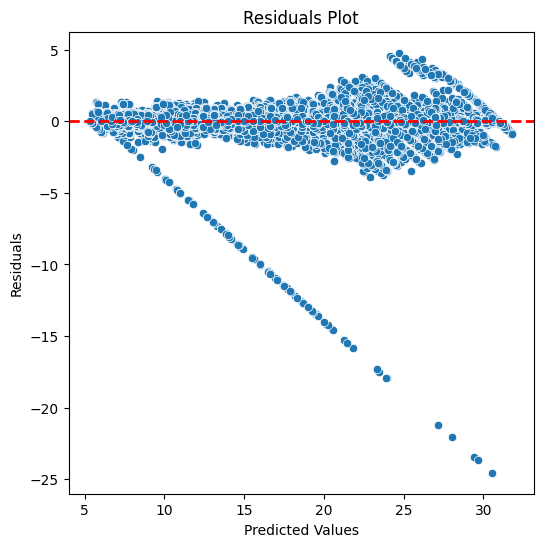

In [65]:
plot.plot_residuals(y_test, y_pred)

We see a better residual distribution with tighter variance around the 0 axis. The 'stray' residual line we saw in on the baseline model residual plot is still present. The unclustered residuals are most likely from the interest rate prediction from one of the super minority loan sub-grades which has barely any presence in the dataset. This is an obvious limitation of the model

#### Export the models

Loan sub-grade classifier

In [66]:
filename = 'sub_grade_clf.sav'
joblib.dump(subgrade_clf,filename)

['sub_grade_clf.sav']

Loan interest rate predictor

In [67]:
filename = 'int_rate_pred.sav'
joblib.dump(intrate_reg,filename)

['int_rate_pred.sav']

## Conclusions

Loan sub-grade and interest rate were predicted using baseline models (LightGBM and Linear Regression) and evaluated, baseline results:

- Loan Sub-Grade multiclass classifier using LightGBM classifier: Macro F1 score: 0.23
- Loan Interes Rate regression using Linear Regression: RSME: 0.86  , Adjusted R-squared: 0.97

Two machine learning models were created and hyperparameters tuned using Optuna, results on  holdout test set:

- Loan Sub-Grade multiclass classifier using LightGBM Classificator: Macro F1 score: 0.23
- Loan Interest Rate regression using LightGBM Regressor: RSME: 0.42  , Adjusted R-squared: 0.99

The loan sub grade classification model is not performing to a standard that would be acceptable in production for automated loan evaluation purposes, mainly because of the high cardinality of the feature and very small numbers of lower sub-grade loans present in the dataset.


## Future improvements

The project would greatly benefit from  domain expert input on feature treatment and threshold values for features such as FICO risk scores , debt to income ratios. Another area to explore would be the credit policy change and the drivin factors behind it, instead of the timestamp that is used for the underlying pattern an external signal like federal set interest rates and inflation.
The loan grade and subgrade strategy should also be reflected in the model, as we saw a gradual decline of lowest grade loans issued in the last couple of years. If Lending Club has made a decision to minimze the lowest grade loans the model may exclude these options.

- Optimize the Optuna use with pruning
- Undersample to potentially improve model metrics on minority classes
- Adjust the model to more recent data patterns
- Optimize and automate feature seleciton based on model feature importance and/or SHAP analysis